## Environment preparation

### Imports

In [1]:
import os
import csv
import torch
import pandas as pd
import matplotlib.pyplot as plt

from gpolnel.utils.datasets import load_boston
from torch.utils.data import TensorDataset, DataLoader

from gpolnel.problems.inductive_programming import SML
from gpolnel.utils.utils import train_test_split
from gpolnel.utils.ffunctions import Ffunctions
from gpolnel.utils.inductive_programming import function_map
from gpolnel.algorithms.genetic_algorithm import GeneticAlgorithm
from gpolnel.operators.initializers import grow, full, rhh, prm_grow, ERC, prm_full
from gpolnel.operators.variators import swap_xo, prm_subtree_mtn, prm_point_mtn, prm_hoist_mtn
from gpolnel.operators.selectors import prm_tournament, prm_roulette_wheel, prm_rank_selection, prm_rnd_selection, prm_double_tournament


### Global settings

In [2]:
seed = 19
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'mps' if torch.backends.mps.is_available() else 'cpu'
    

### Data load

In [3]:
# Defines parameters for the data usage
shuffle, p_test, p_val, n_batches_pct = True, .3, .3, 1


In [5]:
csv_file_path = './datamart/data_project_nel_final.csv'

# Read the CSV file into a DataFrame
dt = pd.read_csv(csv_file_path)
X = torch.from_numpy(dt.values[:, :-1]).float().to(device)

In [6]:
csv_file_path = './datamart/y_lactose.csv'

y_lactose = pd.read_csv(csv_file_path)
y = torch.from_numpy(y_lactose.values[:, -1]).float().to(device)

In [7]:
print(X.shape, y.shape)
print(X[:3])
print(y[:3])

torch.Size([324, 12]) torch.Size([324])
tensor([[ 2.5000,  2.7273,  2.0000, -0.5206, -1.3631, -0.5860,  0.7581, -0.5366,
          0.8808,  0.0000,  0.0000, -0.4190],
        [ 3.0000,  3.4545,  0.8657, -0.7277,  0.6837, -0.3605,  1.0324, -0.8866,
          0.0796,  0.0000,  0.0000, -0.6626],
        [ 2.0000,  2.6818,  0.0299,  0.3326,  0.0628,  0.4168, -0.0605, -0.6421,
          0.1936,  0.0000,  0.1330, -0.5441]])
tensor([4.9535, 4.9831, 4.8891])


In [8]:
# Data split

# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=p_test, seed=seed)

# Train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, p_test=p_val, seed=seed)
total_batches = 1
batch_size = X_train.shape[0]
print('Batch size: {}\nTotal batches: {}\n'.format(batch_size, total_batches))

print('Train:\t{}\nVal:\t{}\nTest:\t{}'.format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))
print('Total:\t{}'.format(X_train.shape[0] + X_val.shape[0] + X_test.shape[0]))

# Creates training and validatation data sets
ds_train = TensorDataset(X_train, y_train)
ds_val = TensorDataset(X_val, y_val)
ds_test = TensorDataset(X_test, y_test)

# Creates training and test data loaders
dl_train = DataLoader(ds_train, batch_size, shuffle)
dl_val = DataLoader(ds_val, batch_size, shuffle)
dl_test = DataLoader(ds_test, batch_size, shuffle)

Batch size: 159
Total batches: 1

Train:	159
Val:	68
Test:	97
Total:	324


## **GENETIC PROGRAMMING (GP)**

## Grid search

Create combinations for grid search

In [9]:
from itertools import product
import random
from itertools import product, combinations

# Set a seed for reproducibility
random_seed = 19
random.seed(random_seed)

selected_function_combinations = [
    (function_map['add'], function_map['sub'], function_map['mul'], function_map['div']),
    (function_map['add'], function_map['sub'], function_map['mul'], function_map['div'], function_map['log']),
    (function_map['add'], function_map['sub'], function_map['mul'], function_map['div'], function_map['exp'], function_map['tanh']),
]

constant_sets = [ERC(-1., 1.), ERC(-5., 5.), ERC(-10., 10.)]
p_constants_values = [0.05, 0.1, 0.2]
max_init_depth_values = [3, 5, 7]
max_depth_values = [10, 15, 20]

# Generate all combinations of the parameters
sspace_combinations = list(product(selected_function_combinations, constant_sets, p_constants_values, max_init_depth_values, max_depth_values))

initializers = [grow, full, rhh]  
selectors = [prm_tournament, prm_roulette_wheel, prm_rank_selection, prm_rnd_selection, prm_double_tournament] 
crossovers = [swap_xo]
mutations = [prm_hoist_mtn, prm_subtree_mtn, prm_hoist_mtn] 
ps = [50, 100, 250, 500]
selection_pressure = [0.05, 0.1, 0.2]
mutation_prob = [0.01, 0.05, 0.1]
xo_prob = [0.7, 0.8, 0.9]
has_elitism = [True, False]
allow_reproduction = [True, False]

# Generate all combinations of the genetic algorithm parameters
ga_combinations = list(product(initializers, selectors, crossovers,mutations, ps, selection_pressure, mutation_prob, xo_prob, has_elitism, allow_reproduction))

# Combine both sets of combinations for full testing
all_combinations = [ga_params + sspace_params for ga_params, sspace_params in product(ga_combinations, sspace_combinations)]

Choose 10 randomly as it would not be feasible to use all the combinations

In [10]:
selected_combinations = random.sample(all_combinations, 10)

Perform grid search

In [11]:
best_sol = float('inf')
best_params = {}

def test_genetic_algorithm(fset, cset, p_constants, max_init_depth, max_depth, initializer, selector, crossover, mutator, ps, selection_pressure, mutation_prob, xo_prob, has_elitism, allow_reproduction):
    global best_sol, best_params

    sspace_sml = {
    'n_dims': X.shape[1],
    'function_set': fset, 
    'constant_set': cset,
    'p_constants': p_constants,
    'max_init_depth': max_init_depth,
    'max_depth': max_depth, 
    'n_batches': total_batches,
    'device': device
    }

    pi_sml = SML(
    sspace=sspace_sml,
    ffunction=Ffunctions('rmse'),
    dl_train=dl_train, dl_test=dl_val,  # For the algorithm, the unseen is our validation!
    n_jobs=8
    )

    if mutator==prm_subtree_mtn:
        if initializer==grow:
            mutator = prm_subtree_mtn(initializer=prm_grow(sspace_sml))
        else:
            mutator = prm_subtree_mtn(initializer=prm_full(sspace_sml))
    elif mutator==prm_point_mtn:
        mutator = prm_point_mtn(sspace=sspace_sml, prob=mutation_prob)
    else:
        mutator=mutator()
        
    if selector==prm_tournament:
        selector = prm_tournament(pressure=selection_pressure)
    elif selector==prm_double_tournament:
        selector = prm_double_tournament(pressure1=selection_pressure, pressure2=selection_pressure)
    else:
        selector = selector()
        
    mheuristic = GeneticAlgorithm(
        pi=pi_sml,
        initializer=initializer,
        selector=selector,
        crossover=crossover,
        mutator=mutator,
        pop_size=ps,
        p_m=mutation_prob,
        p_c=xo_prob,
        elitism=has_elitism,
        reproduction=allow_reproduction,
        device=device,
        seed=seed
    )

    mheuristic._initialize()  # GP initialization


    # Learning
    n_iter = 50
    mheuristic.solve(
        n_iter, 
        test_elite=True
    )
    
    current_sol = float(mheuristic.best_sol.test_fit.item())
    
    if current_sol < best_sol:
        best_sol = current_sol
        best_params = (
            fset, cset, p_constants, max_init_depth, max_depth, initializer, selector, crossover, mutator, ps, selection_pressure, mutation_prob, xo_prob, has_elitism, allow_reproduction
        )

    return best_params, best_sol

In [12]:
from tqdm import tqdm

for combo in tqdm(selected_combinations, desc="Testing Combinations"):
    initializer, selector, crossover, mutator, ps, selection_pressure, mutation_prob, xo_prob, has_elitism, allow_reproduction, fset, cset, p_constants, max_init_depth, max_depth = combo
    test_genetic_algorithm(fset=fset, cset=cset, p_constants=p_constants, max_init_depth=max_init_depth, max_depth=max_depth, initializer=initializer, 
                           selector=selector, crossover=crossover, mutator=mutator, ps=ps, selection_pressure=selection_pressure, mutation_prob=mutation_prob, xo_prob=xo_prob, has_elitism=has_elitism, allow_reproduction=allow_reproduction)
print(f"Best Parameters: {best_params}")
print(f"Best Solution: {best_sol}")

Testing Combinations: 100%|████████████████████████████████████████████████████████████| 10/10 [05:59<00:00, 35.93s/it]

Best Parameters: ((add, sub, mul, div, log), <gpolnel.operators.initializers.ERC object at 0x00000262C0F58BD0>, 0.1, 3, 15, <function rhh at 0x00000262D10C4F40>, <function prm_double_tournament.<locals>.double_tournament at 0x000002628630E480>, <function swap_xo at 0x00000262D10C40E0>, <function prm_hoist_mtn.<locals>.hoist_mtn at 0x000002628630FB00>, 100, 0.05, 0.05, 0.8, True, True)
Best Solution: 0.06274009495973587


Now that we have the best parameters, we use them to train the model and then evaluate the results on the test set

In [13]:
fset, cset, p_constants, max_init_depth, max_depth, initializer, selector, crossover, mutator, ps, selection_pressure, mutation_prob, xo_prob, has_elitism, allow_reproduction = best_params

In [14]:
best_params

((add, sub, mul, div, log),
 0.1,
 3,
 15,
 <function gpolnel.operators.initializers.rhh(sspace, n_sols)>,
 <function gpolnel.operators.selectors.prm_double_tournament.<locals>.double_tournament(pop, min_criteria)>,
 <function gpolnel.operators.variators.swap_xo(p1, p2)>,
 <function gpolnel.operators.variators.prm_hoist_mtn.<locals>.hoist_mtn(repr_)>,
 100,
 0.05,
 0.05,
 0.8,
 True,
 True)

In [15]:
sspace_sml = {
'n_dims': X.shape[1],
'function_set': fset, 
'constant_set': cset,
'p_constants': p_constants,
'max_init_depth': max_init_depth,
'max_depth': max_depth, 
'n_batches': total_batches,
'device': device
}

pi_sml = SML(
sspace=sspace_sml,
ffunction=Ffunctions('rmse'),
dl_train=dl_train, dl_test=dl_test,  
n_jobs=8
)
    
mheuristic = GeneticAlgorithm(
    pi=pi_sml,
    initializer=initializer,
    selector=selector,
    crossover=crossover,
    mutator=mutator,
    pop_size=ps,
    p_m=mutation_prob,
    p_c=xo_prob,
    elitism=has_elitism,
    reproduction=allow_reproduction,
    device=device,
    seed=seed
)

mheuristic._initialize()  # GP initialization



# Log settings
file_dir = './log_gp/'
file_name = 'intro.log'
log_path = file_dir + file_name
if os.path.exists(file_dir + file_name):
    os.remove(file_dir + file_name)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)

# Learning
n_iter = 50
mheuristic.solve(
    n_iter,
    verbose=3, log=3, log_path=log_path,
    test_elite=True
)


-------------------------------------------------------------------------------------------------------
           |                    Best solution                      |            Population            |
-------------------------------------------------------------------------------------------------------
Generation | Length   Fitness          Test Fitness         Timing | AVG Fitness           STD Fitness
-------------------------------------------------------------------------------------------------------
0          | 13       3.06809          3.36578               0.202 | 21.7816                   47.5191
1          | 1        1.15091          1.16279               0.270 | 4.73247                   1.38224
2          | 4        0.201082         0.189058              0.307 | 4.03028                   1.37358
3          | 5        0.162785         0.173082              0.286 | 3.54142                   2.01553
4          | 5        0.162785         0.173082              0.291 | 

GP Evolution

In [17]:
# Open log file
rows = []
with open(log_path, 'r') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Process each row (each row is a list of values)
        rows.append(row)

# Fitness history
history_fits = [float(row[7].split('(')[1].split(')')[0]) for row in rows]

# Val fitness history
history_val_fits = [float(row[8].split('(')[1].split(')')[0]) for row in rows]

# Solution size history
history_sizes = [int(row[6]) for row in rows]

# Runtime
history_timing = [float(row[5]) for row in rows]

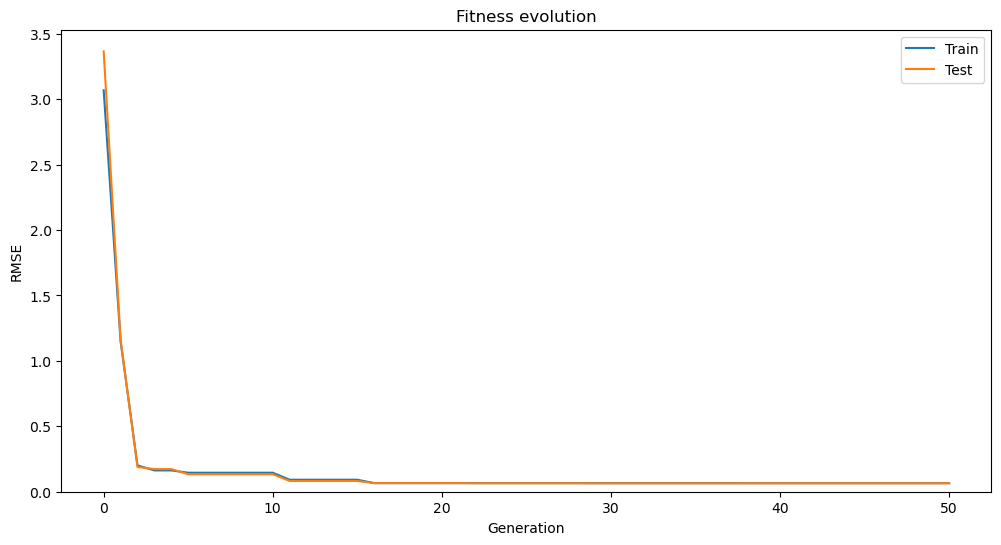

Best solution RMSE fitness: 0.0654 train, 0.0646 test.



In [18]:
plt.figure(figsize=(12, 6))

plt.plot(history_fits, label='Train')
plt.plot(history_val_fits, label='Test')
plt.title('Fitness evolution')
plt.xlabel('Generation')
plt.ylabel('RMSE')
plt.ylim(bottom=0)
plt.legend()
plt.show()

print('Best solution RMSE fitness: {:.4f} train, {:.4f} test.\n'.format(mheuristic.best_sol.fit.item(), mheuristic.best_sol.test_fit.item()))


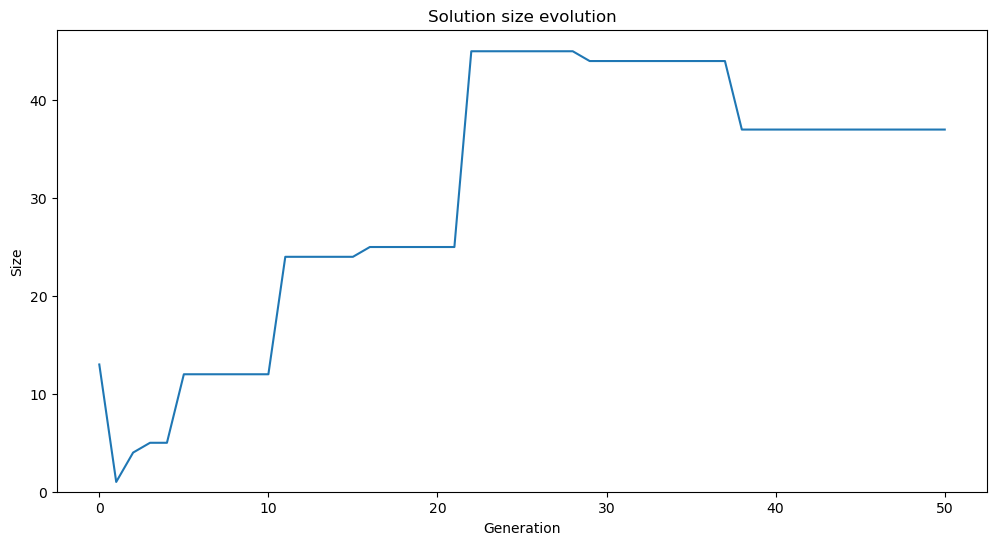

In [19]:
plt.figure(figsize=(12, 6))

plt.plot(history_sizes)
plt.title('Solution size evolution')
plt.xlabel('Generation')
plt.ylabel('Size')
plt.ylim(bottom=0)
plt.show()


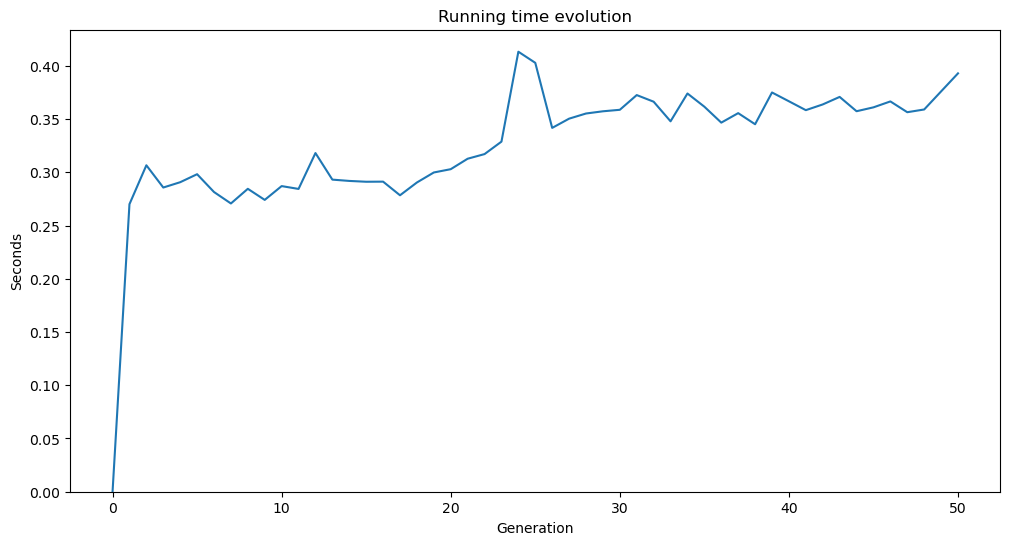

Total time: 0.28 minutes.



In [20]:
plt.figure(figsize=(12, 6))

plt.plot(history_timing)
plt.title('Running time evolution')
plt.xlabel('Generation')
plt.ylabel('Seconds')
plt.ylim(bottom=0)
plt.show()

print('Total time: {:.2f} minutes.\n'.format(sum(history_timing)/60.))
